In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import pandas as pd
import numpy as np

## The data : Blue Book for Bulldozers

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations." 

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

The contents of this notebook are derived from the learning of Jeremy Howards Machine learning course : 

- [Introduction to Machine Learning for Coders](https://www.fast.ai/2018/09/26/ml-launch/)

- [Video Timelines for the 12 lessons of “Intro to Machine Learning”](https://medium.com/@eric.perbos/i-finalized-the-video-timelines-for-the-12-lessons-of-intro-to-machine-learning-8fc9da03d030)

In [3]:
PATH = "data/bulldozers/"
!ls {PATH}

bluebook-for-bulldozers.zip	  Train.7z	     Valid.7z
Data Dictionary.xlsx		  TrainAndValid.7z   Valid.csv
Machine_Appendix.csv		  TrainAndValid.csv  ValidSolution.csv
median_benchmark.csv		  TrainAndValid.zip  Valid.zip
random_forest_benchmark_test.csv  Train.csv
Test.csv			  Train.zip


In [4]:
!ls -lh ./fastai

lrwxrwxrwx 1 jupyter jupyter 21 Sep 18 00:27 ./fastai -> ../fastai/old/fastai/


In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Initial processing

This dataset contains a mix of **continuous** and **categorical** variables.

#### Processing Date-time data

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

Here we use function `add_datepart` from fasta library. You can find its src [here](https://github.com/fastai/fastai/blob/master/old/fastai/structured.py)

In [12]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

#### Converting categorical variables

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [14]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [16]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:

In [17]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

#### Missing variables

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [18]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [19]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

## Pre-processing

In the future we can simply read it from this fast format.

In [20]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable using `proc_df`, you can look at its src [here](https://github.com/fastai/fastai/blob/master/old/fastai/structured.py)

In [22]:
df, y, nas = proc_df(df_raw, 'SalePrice')

We now have something we can pass to a random forest!

In [23]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9831623369536567

In statistics, the coefficient of determination, denoted R2 or r2, is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [24]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid

raw_train, raw_valid = split_vals(df_raw, n_trn)

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forest

## Base model

Let's try our model again, this time with separate training and validation sets.

In [26]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), 
           m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [27]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 19s, sys: 620 ms, total: 1min 19s
Wall time: 15.7 s
[0.09039686961956939, 0.2494237104140377, 0.9829218191221368, 0.8888975988721972]


An r^2 in the high-80's isn't bad at all, but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

### Speeding things up

We'll use a subset aka random sample of the training data when playing with the data to speed things up.

can be easily done by either using `df = get_sample(df,subset)` or with `proc_df`

In [28]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [29]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.05 s, sys: 8 ms, total: 3.06 s
Wall time: 686 ms
[0.11225987827460732, 0.3846471695347507, 0.9726177393278242, 0.7357755175138971]


## Single Tree

In [30]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5220017019686451, 0.5826558234746901, 0.40794233968782023, 0.3937215147205382]


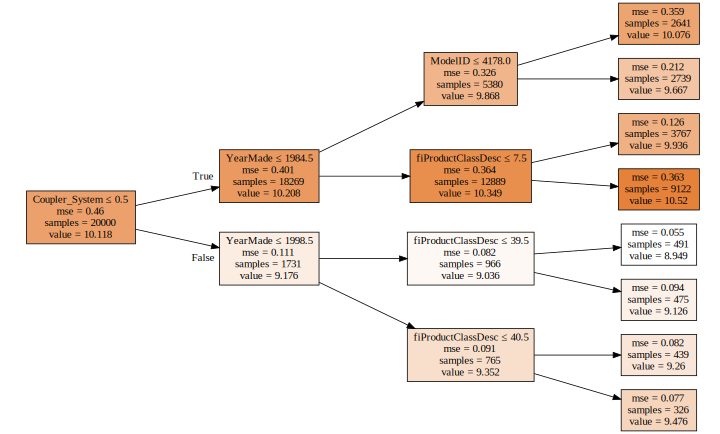

In [31]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [32]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.756054031998178e-17, 0.4982530020105858, 1.0, 0.5566488676101811]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again. (bootstrap = True)

In [33]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.1117448646171337, 0.36195595692436866, 0.9728684057293512, 0.7660304008956643]


We'll grab the predictions for each individual tree, and look at one example.

In [34]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.30565, 9.87817, 9.87817, 9.10498, 9.15905, 9.10498, 9.90349, 9.15905, 9.39266, 9.87817]),
 9.476436313455626,
 9.104979856318357)

In [35]:
preds.shape

(10, 12000)

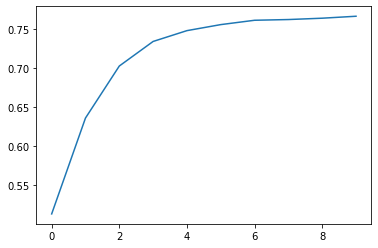

In [36]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [37]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10185621489422435, 0.3778684302365125, 0.9774578553124917, 0.7450064513652721]


In [38]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09386011116483652, 0.3609819834426786, 0.9808582211212818, 0.7672878665273011]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.  

This also has the benefit of allowing us to see whether our model generalizes well in a statistical sense, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

Note : OOB score is generally less good compared to validation/test score because only a subset of trees were used to predict the score for a particular rows( This is because for a given row only those trees in which it was OOB will be used to make a prediction -> [Lesson 5](https://www.youtube.com/watch?v=3jl2h9hSRvc) 7:10)

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [39]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09704114342236828, 0.35734735675600937, 0.9795387587110275, 0.7719505012179203, 0.8550378677024184]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [40]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [41]:
print(len(df_trn), len(X_train))

401125 389125


- The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.


- no dataset is too big for this technique (ex: 120 million rows for grocery store data of Kaggle competition)


- need to set oob_score = False if using subsample approach of `set_rf_samples(20000)` to turn it off, do `reset_rf_samples()`




In [42]:
set_rf_samples(20000)

In [43]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 9.2 s, sys: 956 ms, total: 10.2 s
Wall time: 5.22 s
[0.24079534796766028, 0.27892624965324975, 0.8788199825316171, 0.8610601745374166, 0.8662338874104544]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [45]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22784672233470335, 0.2646586260315125, 0.8915023336829652, 0.8749107233729719, 0.8798309188390689]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.



In [47]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [48]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07834854251222914, 0.2402456360232156, 0.9871708858371925, 0.8969236600401127, 0.9081129333625884]


In [49]:
t=m.estimators_[0].tree_

In [50]:
dectree_max_depth(t)

51

In [51]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14069511517683014, 0.23329794104026894, 0.9586293004327904, 0.9027992119590268, 0.9070870939894604]


In [52]:
t=m.estimators_[0].tree_

dectree_max_depth(t)

37

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1148869338375313, 0.23293108300379747, 0.9724148021047833, 0.9031046656077841, 0.9086285770954909]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

    - None
    - 0.5
    - 'sqrt'
    - 1, 3, 5, 10, 25, 100



In [54]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11908060540201214, 0.22878722039770155, 0.9703641837124477, 0.9065215510042726, 0.9117885984195662]


The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

# Random Forest Model interpretation

In [56]:
set_plot_sizes(12,14,16)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

Details in this [Lesson 2](https://www.youtube.com/watch?v=YSFG_W8JxBo), 58:10.

In [57]:
set_rf_samples(50000)

In [58]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20559337737072425, 0.24744739882727088, 0.9116608801440207, 0.8906512658983075, 0.894641047944049]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent.

Detailed explanation for the stacking below : [Lesson 2](https://www.youtube.com/watch?v=blyXCk4sgEg) , 1:05

We'll grab the prediction for each individual tree. and look at one example.

```
[t.predict(X_valid) for t in m.estimators_]

[array([8.97828, 9.07949, 8.9872 , ..., 9.15346, 9.13063, 9.13063]),
 array([9.0676 , 9.05311, 9.15905, ..., 9.36715, 9.51524, 9.51524]),
 array([9.72667, 9.11145, 9.12741, ..., 9.13132, 9.13132, 9.13132]),
 array([9.43192, 9.03787, 8.94893, ..., 9.69288, 9.03422, 9.03422]),
 .
 .
 array([9.56517, 9.7535 , 9.28813, ..., 9.35789, 9.35789, 9.35789])]

np.stack([t.predict(X_valid) for t in m.estimators_])

array([[8.97828, 9.07949, 8.9872 , ..., 9.15346, 9.13063, 9.13063],
       [9.0676 , 9.05311, 9.15905, ..., 9.36715, 9.51524, 9.51524],
       [9.72667, 9.11145, 9.12741, ..., 9.13132, 9.13132, 9.13132],
       ...,
       [9.59085, 9.42477, 8.99257, ..., 9.94534, 9.31309, 9.31309],
       [9.44767, 9.24552, 9.02992, ..., 9.37498, 9.17196, 9.17196],
       [9.56517, 9.7535 , 9.28813, ..., 9.35789, 9.35789, 9.35789]])
       ```

In [61]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
print(preds[:,0], y_valid[0])
print(np.mean(preds[:,0]), np.std(preds[:,0]))

CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s
[ 8.98589  9.94284  9.33189  9.0899   9.24637 10.38902  9.20889  9.29677  9.05271  9.27972  8.94417 10.31073
  9.03633  9.0768   9.07485  9.44995  9.06572  9.12922  9.14968  9.24558  9.60302  9.69064  9.35696  9.03672
  9.2496   9.22564  9.21987  9.13109  9.22803  9.24116  9.20783  9.15611  9.60768  9.35502  9.852    9.02188
  9.69113  9.25903  9.21886  9.43188] 9.104979856318357
9.327279374525247 0.3275885808059157


When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [62]:
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 80 ms, sys: 156 ms, total: 236 ms
Wall time: 614 ms


(9.327279374525247, 0.3275885808059157)

In [63]:
preds.shape

(40, 12000)

We can see that different trees are giving different estimates in this auction. In order to see how prediction confidence varies, we can add this into our dataset.

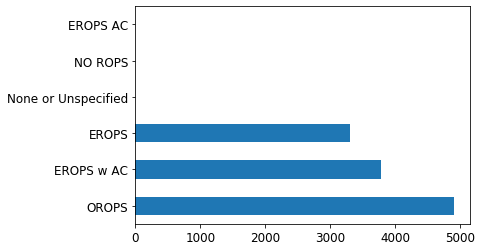

In [64]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [65]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.846572,0.279332
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.568656,0.269900
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683055,0.223912


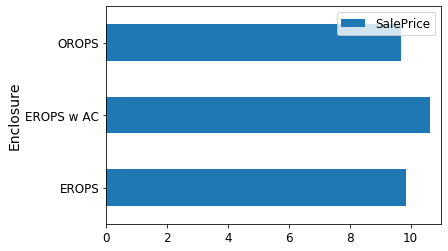

In [66]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

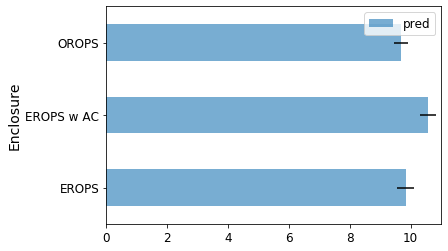

In [67]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

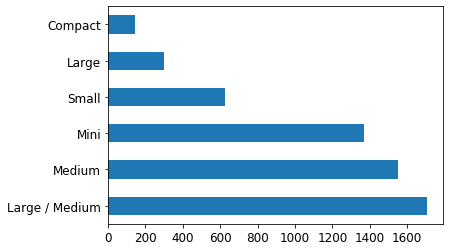

In [68]:
raw_valid.ProductSize.value_counts().plot.barh();

In [69]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.874110,0.362922
Large,10.470589,10.374159,0.363893
Large / Medium,10.691871,10.642271,0.302331
Medium,10.681511,10.619767,0.290064
Mini,9.535147,9.570730,0.260894
Small,10.324448,10.311924,0.323819


In [70]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036755
Large             0.035077
Small             0.031402
Large / Medium    0.028409
Medium            0.027314
Mini              0.027260
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*. 

Note : The default method of calculating Feature importance in  RF, tends to inflate the importance of continuous or high-cardinality categorical variables. *"the variable importance measures of Breiman's original Random Forest method ... are not reliable in situations where potential predictor variables vary in their scale of measurement or their number of categories."*. That's unfortunate because not having to normalize or otherwise futz with predictor variables for Random Forests is very convenient. 


### Permutation importance

Breiman and Cutler also described permutation importance, which measures the importance of a feature as follows. Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. The permutation mechanism is much more computationally expensive than the mean decrease in impurity mechanism, but the results are more reliable. The permutation importance strategy does not require retraining the model after permuting each column; we just have to re-run the perturbed test samples through the already-trained model. 

Tree based models provides a different measure of feature importances based on the mean decrease in impurity (MDI, the splitting criterion). This gives importance to features that may not be predictive on unseen data. The permutation feature importance avoids this issue, since it can be applied to unseen data. Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features). Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may use an arbitrary metric on the tree’s predictions.

Also checkout :
- **[Beware of Default Random Forest Importances](https://explained.ai/rf-importance/)** 
- **[Permutation feature importance ](https://scikit-learn.org/dev/modules/permutation_importance.html)** -scikitlearn 
- **[Permutation Importance vs Random Forest Feature Importance](https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)** -scikitlearn


In [ ]:
??rf_feat_importance

In [71]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.173582
37,Coupler_System,0.100317
13,ProductSize,0.089188
14,fiProductClassDesc,0.083648
39,Hydraulics_Flow,0.059417
2,ModelID,0.054417
63,saleElapsed,0.050682
10,fiSecondaryDesc,0.047073
38,Grouser_Tracks,0.036465
19,Enclosure,0.035811


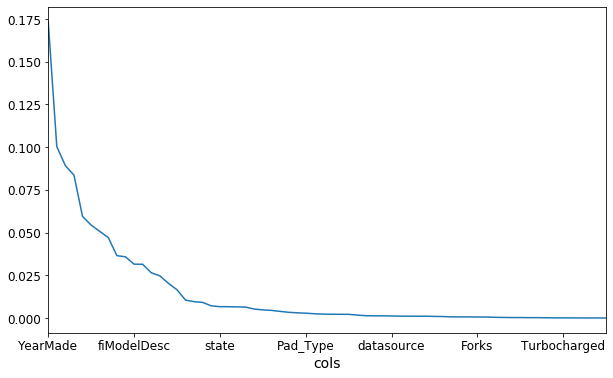

In [72]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [73]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

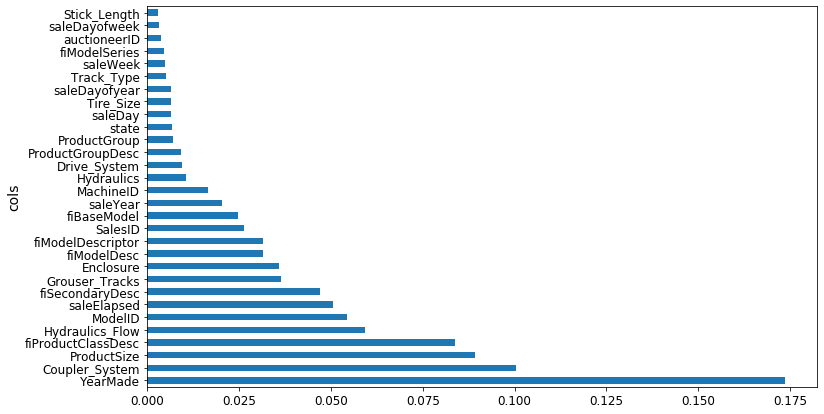

In [74]:
plot_fi(fi[:30]);

In [75]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [76]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [77]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20725606828863521, 0.24588859696518053, 0.9102262562612514, 0.892024617361036, 0.8939726299312983]


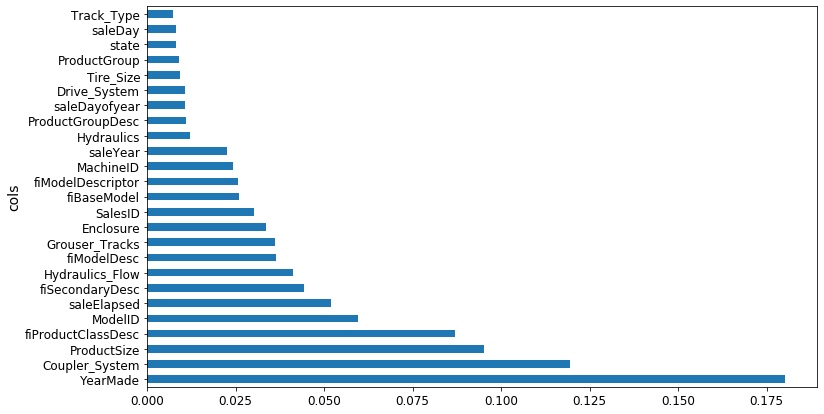

In [78]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [79]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20713356215116632, 0.25306801028242676, 0.9103323528822084, 0.8856272733036457, 0.8926479476822899]


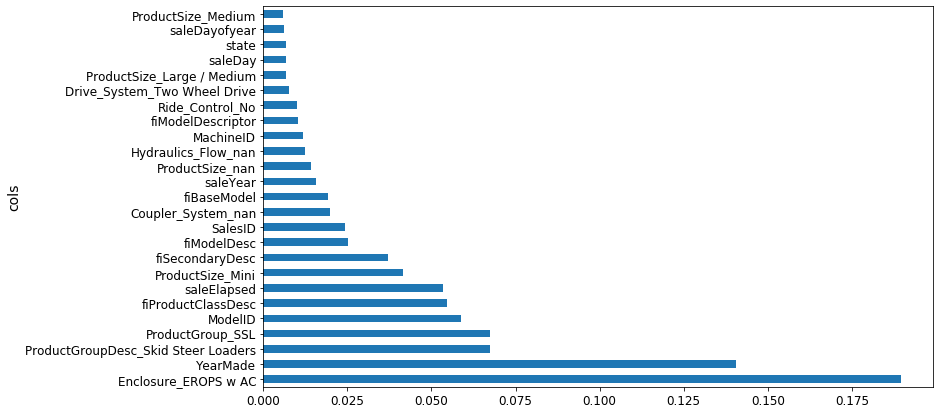

In [80]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.


When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance for both features, where they might actually be important. One way to handle this is to cluster features that are correlated and only keep one feature from each cluster. This use case is explored in: **[Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)**

In [81]:
from scipy.cluster import hierarchy as hc

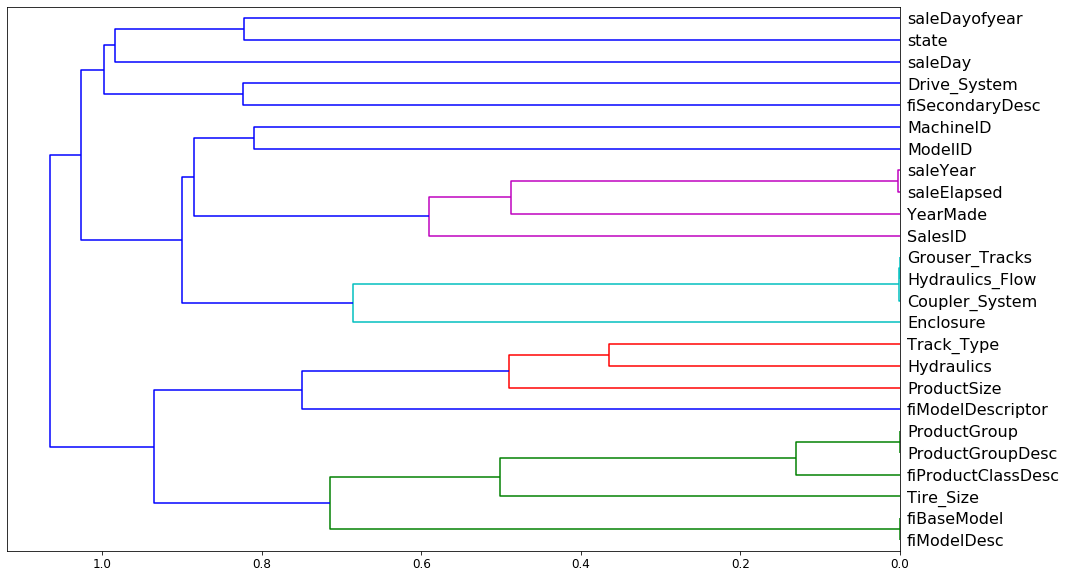

In [82]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [83]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [84]:
get_oob(df_keep)

0.8906437341947209

Now we try removing each variable one at a time.

In [85]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8896359278744902
saleElapsed 0.887866110502875
fiModelDesc 0.8887152232006588
fiBaseModel 0.8889874493133728
Grouser_Tracks 0.8903437325390771
Coupler_System 0.8897479229166875


It looks like we can try one from each group for removal. Let's see what that does.

In [86]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.889144304941874

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [87]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [88]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [89]:
# keep_cols = np.load('tmp/keep_cols.npy')
# df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [90]:
reset_rf_samples()

In [91]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12486853541911529, 0.22690480559338047, 0.9674132640218543, 0.9080534662304038, 0.9090587240580934]


# Partial dependence

In [71]:
from pdpbox import pdp
from plotnine import *

In [73]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [74]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

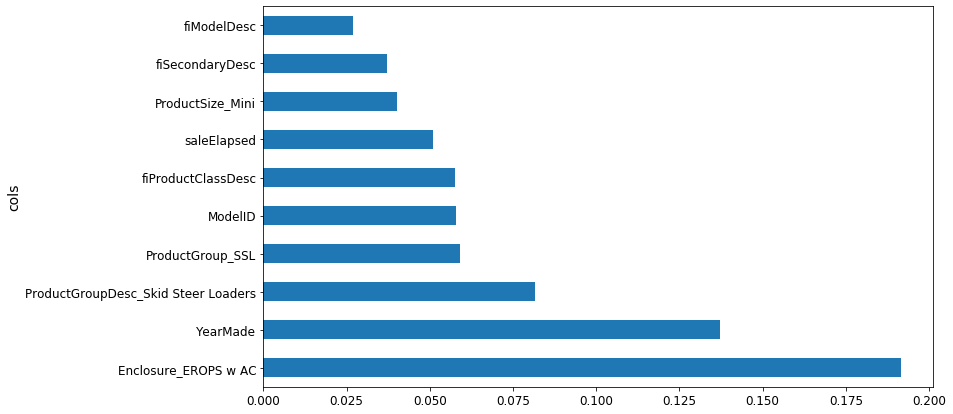

In [75]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

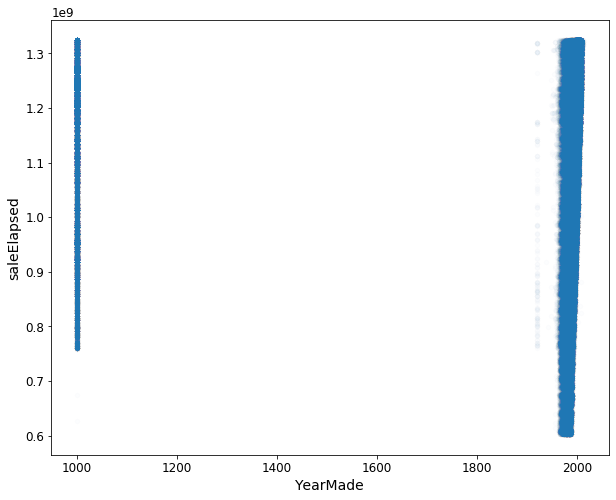

In [76]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [77]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

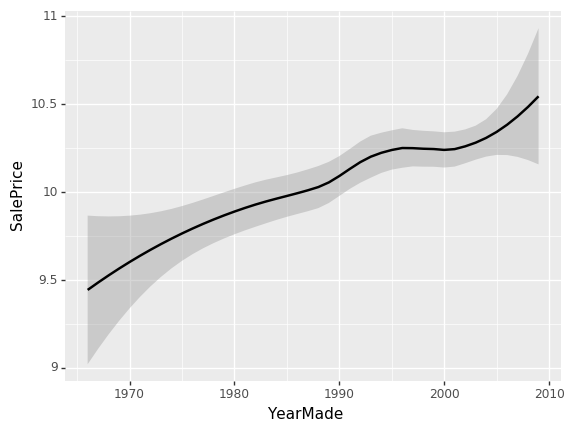

<ggplot: (8770640093701)>

In [79]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [80]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [88]:
# def plot_pdp(feat, clusters=None, feat_name=None):
#     feat_name = feat_name or feat
#     p = pdp.pdp_isolate(m, x, feat)
#     return pdp.pdp_plot(p, feat_name, plot_lines=True,
#                         cluster=clusters is not None,
#                         n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa12db21fd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa12db7fa10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


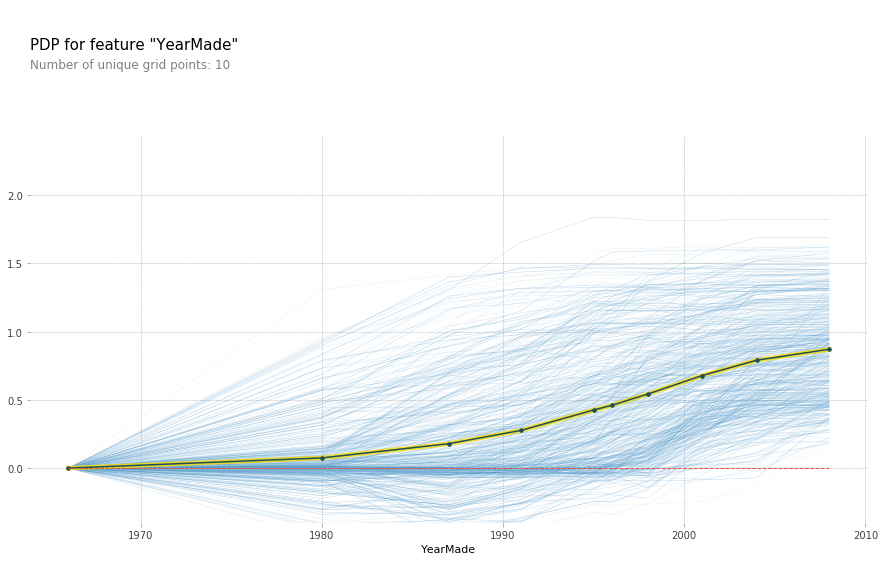

In [89]:
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

plot_pdp(feat_name='YearMade')

### How to select validation Set :

Generally random sampling works well.

Random sampling for validation sets can give an inaccurate idea of whether a model can generalize ([Lesson 5](https://www.youtube.com/watch?v=3jl2h9hSRvc) 16:00) in some cases :

1. There is temporal ordering in data
2. Class imbalance
3. Lag between training data and the data being used in real life. 


If there is some temporal ordering in the data, so in that case, is it wise to take the entire data for training or only a few recent dataset for training [19:07](https://www.youtube.com/watch?v=3jl2h9hSRvc)

Most machine learning functions have the ability to provide a weight that is given to each row. So for example, with a random forest, rather than bootstrapping at random, you could have a weight on every row and randomly pick that row with some probability. So we could put probability such that the most recent rows have a higher probability of being selected. That can work really well.

### Cross-validation :

- Can be useful when random sampling of subsets is okay for validation. 
- Also useful when you have a small training data.

Drawbacks :

1. Computationally expensive for large data set.
2. If a random validationset is not appropriate for your problem - ex, in case of temporal data, then same applies for cross validation. 


# Tree interpreter


- Explain one prediction aka feature interpretation for a specific observation.
- Waterfall plots
- More : [38:05](https://www.youtube.com/watch?v=3jl2h9hSRvc) 


In [ ]:
from treeinterpreter import treeinterpreter as ti

In [102]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [103]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          1,          0,
                 0,       3232,    4364751,    2300944,          0,          4,          0,         12,
                35,         16,        259,          4,          2,         29,          0,         11]])

In [104]:
prediction, bias, contributions = ti.predict(m, row)

In [105]:
prediction[0], bias[0]

(array([9.29387]), 10.10474328852106)

In [108]:
contributions

array([[ 0.08426,  0.06592, -0.5327 , -0.19246,  0.06962, -0.0053 , -0.05275, -0.05818,  0.02639, -0.06795,
         0.00096,  0.01666, -0.02896,  0.00166,  0.00329, -0.00585, -0.00183, -0.01146, -0.00761,  0.02518,
         0.01194, -0.01226, -0.00878, -0.13065]])

In [106]:
idxs = np.argsort(contributions[0])

In [107]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.532703001897301),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.19245888234387434),
 ('age', 11, -0.13065442637665656),
 ('fiModelDesc', 'KX1212', -0.06794647850584426),
 ('fiSecondaryDesc', nan, -0.0581807426606054),
 ('Enclosure', 'EROPS', -0.052752317109081216),
 ('fiModelDescriptor', nan, -0.02896180816424341),
 ('Stick_Length', 'None or Unspecified', -0.012258980443337864),
 ('saleDay', 16, -0.01146421746744557),
 ('Tire_Size', nan, -0.008776113247195471),
 ('saleDayofyear', 259, -0.0076123530558540155),
 ('Hydraulics', 'Standard', -0.005850313844188326),
 ('saleElapsed', 1284595200, -0.005300526584282617),
 ('state', 'Ohio', -0.0018342898237651006),
 ('SalesID', 4364751, 0.0009602888545159783),
 ('ProductGroup', 'TEX', 0.001664145212059731),
 ('Drive_System', nan, 0.003292716077059943),
 ('Track_Type', 'Steel', 0.011943218042459191),
 ('MachineID', 2300944, 0.016662719427578042),
 ('ProductGroupDesc', 'Track Exca

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

RF can’t extrapolate like Linear Model. 
Trick: find the differences between Train and Valid sets, ie. any temporal predictor ? Build a RF to identify components present in Valid only and not in Train `x,y = proc_df(df_ext, ‘is_valid’)`

[48:50](https://www.youtube.com/watch?v=3jl2h9hSRvc)

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


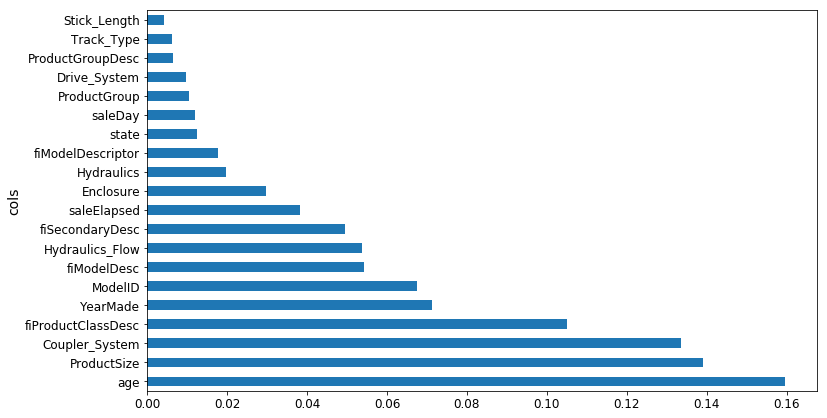

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
